In [1]:
import os

if (os.path.basename(os.getcwd()) == 'Notebooks'):
    os.chdir('..')
    
os.getcwd()

'c:\\Users\\sebastian\\SynologyDrive\\Studium\\10.Semester\\Wettbewerb\\project\\code\\KISMED'

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)

import csv
import scipy.io as sio
import os
from scipy import interpolate

from wettbewerb import load_references
from utils.utils import load_test_references

# Collect Data/ECGs

## Helpful methods

In [4]:
def plot_labels_distr(labels, name='Data set'):
    counts = pd.Series(labels).value_counts()
    print(counts)
    plt.pie(counts, labels=counts.index,autopct='%1.1f%%')
    plt.title(name)
    plt.show()

def compare_data_set(ds_base, ds_compare):
    arr_base_id = []
    arr_compare_id = []
    found = 0
    
    for i, db in enumerate(ds_base):
        
        use_ds_compare_ids = np.setdiff1d(np.arange(0,len(ds_compare)), arr_compare_id)
        
        for j in use_ds_compare_ids:
            if np.array_equal(db,ds_compare[j]):
                arr_base_id.append(i)
                arr_compare_id.append(j)
                found += 1
                break
    print('Found: ' + str(found/len(ds_base)*100) + '%')

    return (arr_base_id, arr_compare_id)


def interpolate_ecg(ecg_lead, fs_in, fs_out):
    t = np.linspace(0, len(ecg_lead)/fs_in, len(ecg_lead))
    
    f = interpolate.interp1d(t, ecg_lead)

    t_interpol = np.arange(0, len(ecg_lead)/fs_in, 1/fs_out)
    ecg_lead_interpol = f(t_interpol)

    return t_interpol, ecg_lead_interpol

In [5]:
# all paths with new data
PATH_BASE = "data/training/"
PATH_CINC = "data/others/CINC/fs_300/"
PATH_CINC_TEST = "data/others/CINC/test/"

PATH_CPSC_KAGGLE = 'data/others/Training_WFDB/'
PATH_CPSC_500 = 'data/others/CPSC/fs_500/'
PATH_CPSC_300 = 'data/others/CPSC/fs_300/'
PATH_CPSC_ORIG = 'data/others/ORIGINAL/'

PATH_CU_500 = 'data/others/CU_SPH/fs_500/'
PATH_CU_300 = 'data/others/CU_SPH/fs_300/'
PATH_CU_ORIG = 'data/others/CU_SPH/ECGData/'

## PhysioNet
- Some of the ecgs are duplicates? (some are several times there; e.g. 2x)
- all 6000 ecgs are part of the physionet2017/CinC
- Distribution stays the same
- 'REFERENCE-original.csv': less of category noise...
- Sampling frequency: 300Hz
- Band pass filtered by the AliveCor device
- Amplitude: 1000/mV


### Compare with given data set

In [6]:
# get both data set ecg_leads
ecg_leads01, ecg_labels01, fs, ecg_names01 = load_references(folder=PATH_BASE)
ecg_leads02, ecg_labels02, fs, ecg_names02 = load_references(folder=PATH_CINC)

# compute link table 
base_ids, compare_ids = compare_data_set(ecg_leads01, ecg_leads02)
df_links = pd.DataFrame(np.array([base_ids, compare_ids]).T, columns=['Base', 'CinC'])

# # if wanted can be stored
# df_links.to_csv(PATH_CINC+ '/COMPARE.csv', index=False)
df_links

6000	 Dateien wurden geladen.
8528	 Dateien wurden geladen.
Found: 100.0%


,Base,CinC
0,0,8136
1,1,4212
2,2,7741
3,3,4927
4,4,1973
...,...,...
5995,5995,2784
5996,5996,1583
5997,5997,1667
5998,5998,5038


### Create a test set out of the remaining ecgs

In [7]:
idx_not_included =  np.setdiff1d(np.arange(0,len(ecg_names02)), df_links['CinC'].to_numpy())

# create RESOURCE.csv
ecg_names03 = np.array(ecg_names02)[idx_not_included]
ecg_labels03 = np.array(ecg_labels02)[idx_not_included]

df_reference = pd.DataFrame(np.array([ecg_names03,ecg_labels03]).T)
#df_reference.to_csv(PATH_CINC_TEST+'REFERENCE.csv', index=False, header=False)
df_reference.head()

# store the .mat-files in folder
# for i in idx_not_included:
#     sio.savemat(PATH_CINC_TEST+ecg_names02[i]+'.mat', {"val": np.array([ecg_leads02[i]])})

,0,1
0,A00001,N
1,A00002,N
2,A00004,A
3,A00009,A
4,A00010,N


In [8]:
ecg_leads03, ecg_labels03, fs, ecg_names03 = load_references(folder=PATH_CINC_TEST)
base_ids02, compare_ids02 = compare_data_set(ecg_leads01, ecg_leads03)

2528	 Dateien wurden geladen.
Found: 0.016666666666666666%


#### Create a new RESOURCE.csv without duplicate ecgs within the data set

In [9]:
idx_not_included =  np.setdiff1d(np.arange(0,len(ecg_names03)), compare_ids02)

# create RESOURCE.csv
ecg_names04 = np.array(ecg_names03)[idx_not_included]
ecg_labels04 = np.array(ecg_labels03)[idx_not_included]

df_reference = pd.DataFrame(np.array([ecg_names04,ecg_labels04]).T)
#df_reference.to_csv(PATH_CINC_TEST+'REFERENCE.csv', index=False, header=False)
df_reference.head()

,0,1
0,A00001,N
1,A00002,N
2,A00004,A
3,A00009,A
4,A00010,N


In [16]:
ecg_leads03, ecg_labels03, fs, ecg_names03 = load_test_references() # load_references(folder=PATH_CINC_TEST)
base_ids03, compare_ids03 = compare_data_set(ecg_leads01, ecg_leads03)

2527	 Dateien wurden geladen.
Found: 0.0%


### Category histogram

8528	 Dateien wurden geladen.


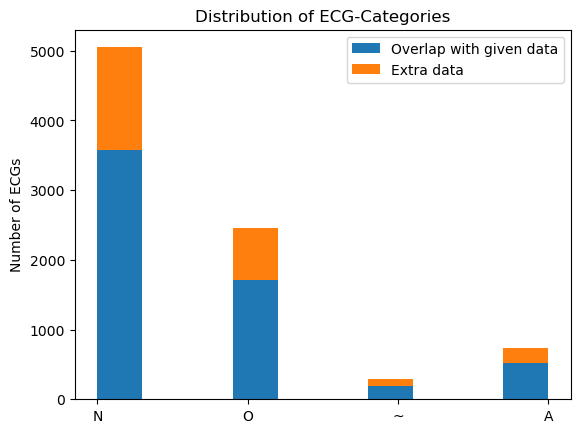

In [8]:
#load needed data
df_links = pd.read_csv(PATH_CINC+'/COMPARE.csv')
_, ecg_labels, _, _ = load_references(folder=PATH_CINC)


idx_old = df_links['CinC'].to_numpy()
idx_new = np.setdiff1d(np.arange(0,len(ecg_labels)), idx_old)

ecg_labels_old = np.array(ecg_labels)[idx_old]
ecg_labels_new = np.array(ecg_labels)[idx_new]

plt.hist([ecg_labels_old,ecg_labels_new], histtype='barstacked', label=['Overlap with given data', 'Extra data'])
plt.title('Distribution of ECG-Categories')
plt.ylabel('Number of ECGs')
plt.legend()
plt.show()

## China Physiological Signal Challenge 2018

- almost same data set: Training_WFDB vs. Original
  - Training_WFDB: values multiplied by 1000 and rounded (i.e. unit mV)
  - 4 ECGs are differing in one value each
  - Training_WFDB: counts all labels of each ecg (on Original-Website: only first label)
- fs=500Hz
  

### Transform into readable data

#### Load data

In [7]:
# Source: https://www.kaggle.com/datasets/bjoernjostein/china-physiological-signal-challenge-in-2018

ecg_leads = []
ecg_labels = []
ecg_filenames = []

for _, _, files in sorted(os.walk(PATH_CPSC_KAGGLE)):
    for filename in files:
        if filename.split('.')[1] == 'mat':
            # collect ecg_lead
            data = sio.loadmat(PATH_CPSC_KAGGLE+filename)
            ecg_leads.append(data['val'][1])  # collect only the leadII

            # get label (AF: 164889003; N: 426783006 => SNOMED)
            with open(PATH_CPSC_KAGGLE+filename.replace('.mat','.hea'),'r') as f:
                header=f.readlines()
            
            lbl_tmp = header[15][5:-1].split(',')
            if ('164889003' in lbl_tmp) or ('426783006' in lbl_tmp):
                ecg_filenames.append(filename.split('.')[0])
            
                if ('164889003' in lbl_tmp):
                    ecg_labels.append('A')
                if ('426783006' in lbl_tmp):
                    ecg_labels.append('N')
            else:
                ecg_filenames.append(filename.split('.')[0])
                ecg_labels.append('O')

In [8]:
# Source: http://2018.icbeb.org/Challenge.html

ecg_leads02 = []
ecg_labels02 = []
ecg_filenames02 = []

with open(PATH_CPSC_ORIG+'REFERENCE.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')

    next(csv_reader)  # ignore first row
    for row in csv_reader:
        # store ecg leads
        data = sio.loadmat(os.path.join(PATH_CPSC_ORIG, row[0] + '.mat'))
        ecg_lead = data['ECG'][0][0][2][1]  # leadII
        ecg_leads02.append(ecg_lead)

        # store labels
        if '1' in row[1:4]:
            ecg_labels02.append('N')
            if '2' in row[1:4]:
                print('FAIL')
        elif '2' in row[1:4]:
            ecg_labels02.append('A')
        else:
            ecg_labels02.append('O')

        # store filename
        ecg_filenames02.append(row[0])
        
print("{}\t Dateien wurden geladen.".format(len(ecg_leads)))

6877	 Dateien wurden geladen.


#### Compare data sets
- almost the same
- still better to cite the original


In [9]:
ecg_leads03 = [np.round(ecgl02*1000).astype(np.int16) for ecgl02 in ecg_leads02]  # change unit and dtype
base_ids, compare_ids = compare_data_set(ecg_leads, ecg_leads03)
print(np.unique(ecg_labels, return_counts=True))
print(np.unique(ecg_labels02, return_counts=True))

Found: 99.94183510251563%
(array(['A', 'N', 'O'], dtype='<U1'), array([1221,  918, 4738], dtype=int64))
(array(['A', 'N', 'O'], dtype='<U1'), array([1221,  918, 4738], dtype=int64))


#### Store needed files for general usage

In [11]:
# # create a REFERENCE.csv
# df_reference = pd.DataFrame(np.array([ecg_filenames02,ecg_labels02]).T)
# df_reference.to_csv(PATH_CPSC_500+'REFERENCE.csv', index=False, header=False)

# # create .mat-files
# for i, filename in enumerate(ecg_filenames02):
#     sio.savemat(PATH_CPSC_500+filename+'.mat', {"val": np.array([ecg_leads03[i]])})

#### Store downsampled ECGs

In [35]:
# DONWSAMPLED

# # create a REFERENCE.csv
# df_reference = pd.DataFrame(np.array([ecg_filenames02,ecg_labels02]).T)
# df_reference.to_csv(PATH_CPSC_300+'REFERENCE.csv', index=False, header=False)

# # create .mat-files
# for i, filename in enumerate(ecg_filenames02):

#     _, ecg_lead_interpol = interpolate_ecg(ecg_leads02[i], fs_in=500, fs_out=300)
#     ecg_lead_interpol = np.round(ecg_lead_interpol*1000).astype(np.int16)

#     sio.savemat(PATH_CPSC_300+filename+'.mat', {"val": ecg_lead_interpol})

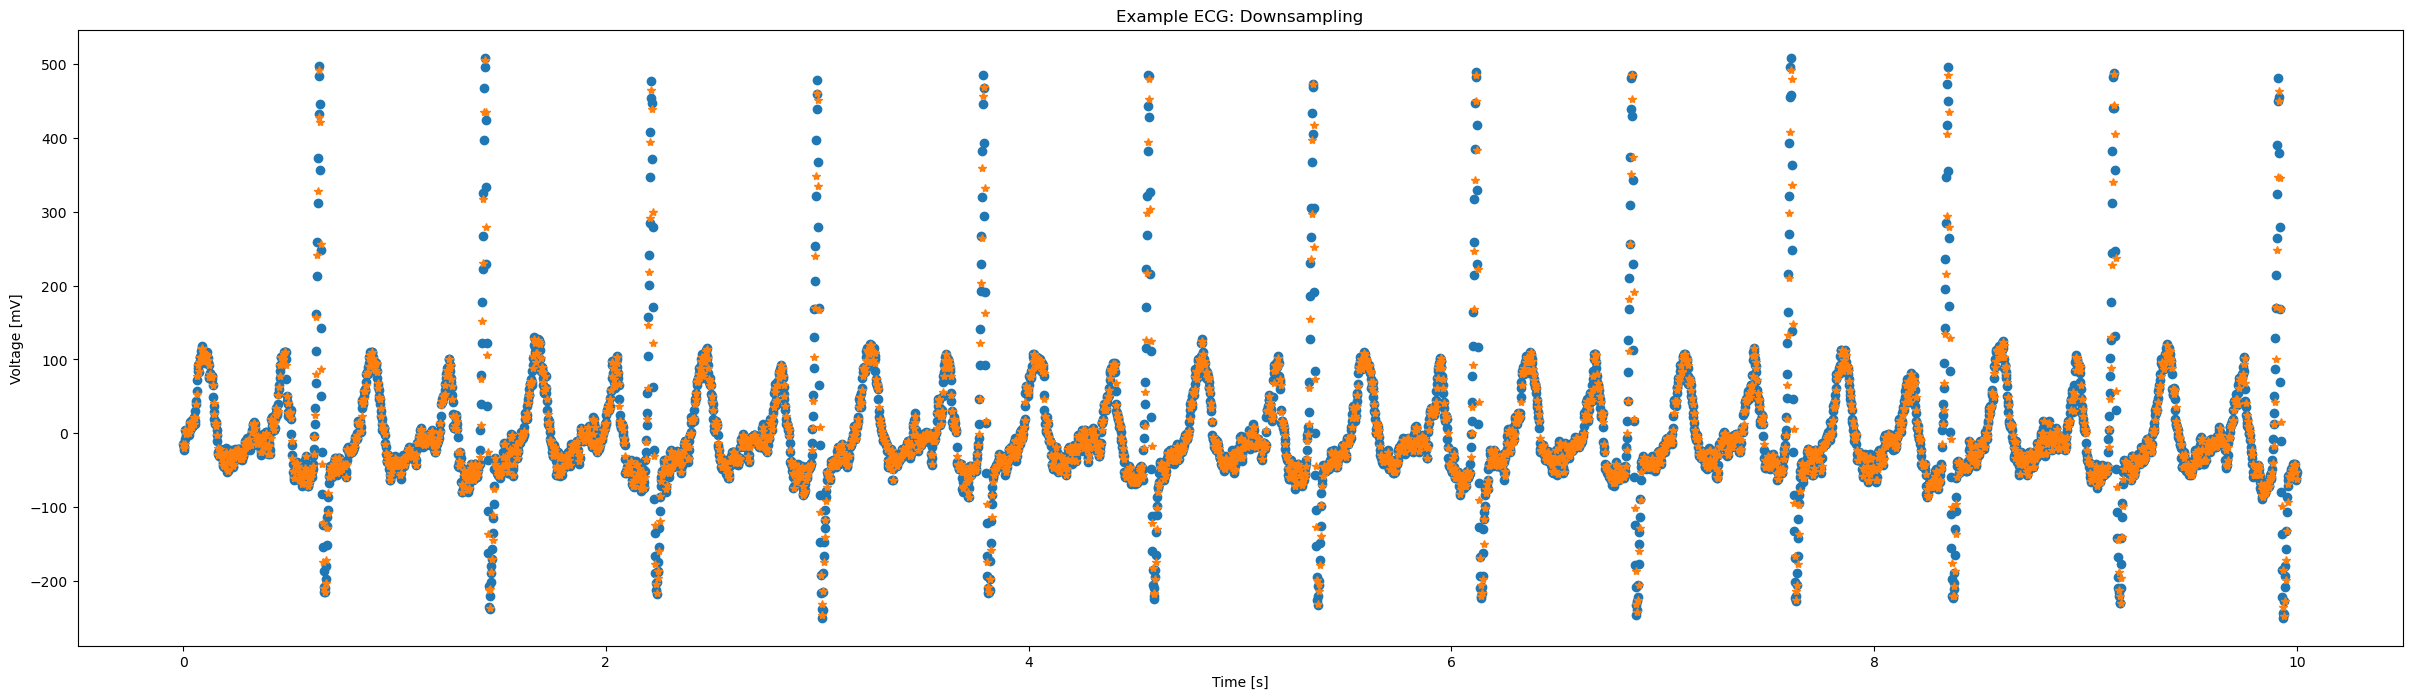

In [9]:
# get example data (
ecg_fs_500 = sio.loadmat(PATH_CPSC_500+'A0002.mat')['val'][0]
ecg_fs_300 = sio.loadmat(PATH_CPSC_300+'A0002.mat')['val'][0]

# TEST
plt.figure(figsize=(30, 8))
plt.plot(np.linspace(0, len(ecg_fs_500)/500, len(ecg_fs_500)), ecg_fs_500, 'o', np.linspace(0, len(ecg_fs_300)/300, len(ecg_fs_300)), ecg_fs_300, '*')
plt.title('Example ECG: Downsampling')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [mV]')
plt.show()

### Category histogram

8528	 Dateien wurden geladen.
6877	 Dateien wurden geladen.


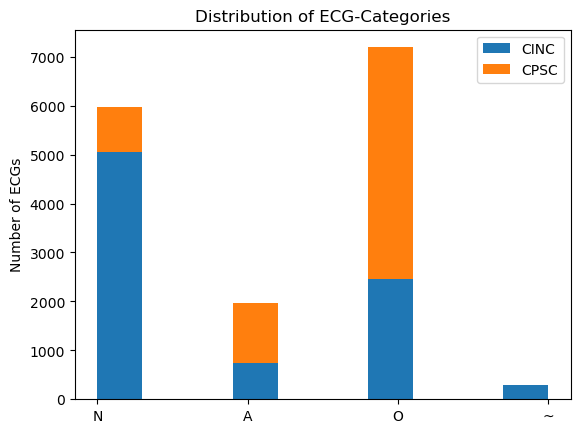

In [10]:
_, ecg_labels01, _, _ = load_references(folder=PATH_CINC)
_, ecg_labels02, _, _ = load_references(folder=PATH_CPSC_300)

plt.hist([ecg_labels01,ecg_labels02], histtype='barstacked', label=['CINC', 'CPSC'])
plt.title('Distribution of ECG-Categories')
plt.ylabel('Number of ECGs')
plt.legend()
plt.show()

## Chapman University and Shaoxing People’s Hospital

- Unit: mV
- Frequency: 500Hz

### Transform into readable data
- ecg_leads: converted into int16 (i.e. round & converted)

In [14]:
# get labels
df_chapman = pd.read_excel('data/others/CU_SPH/ORIGINAL/Diagnostics.xlsx', engine='openpyxl')
labels = df_chapman['Rhythm'].to_numpy()
labels = np.where(labels == 'AFIB', 'A', labels)
labels = np.where(labels == 'SR', 'N', labels)
labels = np.where((labels != 'A') & (labels != 'N'), 'O', labels)
labels

array(['A', 'O', 'O', ..., 'O', 'O', 'O'], dtype=object)

#### Store needed files for general usage

In [16]:
# create a REFERENCE.csv
# df_reference = pd.DataFrame(np.array([df_chapman['FileName'].to_numpy(),labels]).T)
# df_reference.to_csv(PATH_CU_500+'REFERENCE.csv', index=False, header=False)
# np.unique(df_reference, return_counts=True)

(array(['A', 'MUSE_20180111_155115_19000', 'MUSE_20180111_155154_74000',
        ..., 'MUSE_20181222_204314_78000', 'N', 'O'], dtype=object),
 array([1780,    1,    1, ...,    1, 1826, 7040], dtype=int64))

In [84]:
# # store the ecg leads
# for file_name in df_chapman['FileName'].to_numpy():
#     ecg_lead = pd.read_csv(PATH_CU_ORIG+file_name+'.csv')['II'].to_numpy()  # load ecg_leads
#     ecg_lead = np.round(ecg_lead).astype(np.int16)
#     sio.savemat(PATH_CU_500+file_name+'.mat', {"val": np.array([ecg_lead])})

#### Store downsampled ECGs

In [17]:
# DONWSAMPLED

# # create a REFERENCE.csv
# df_reference = pd.DataFrame(np.array([df_chapman['FileName'].to_numpy(),labels]).T)
# df_reference.to_csv(PATH_CU_300+'REFERENCE.csv', index=False, header=False)

# # create .mat-files
# #for i, filename in enumerate(ecg_filenames02):
# for filename in df_chapman['FileName'].to_numpy():
#     ecg_lead = pd.read_csv(PATH_CU_ORIG+filename+'.csv')['II'].to_numpy()  # load ecg_leads
#     _, ecg_lead_interpol = interpolate_ecg(ecg_lead, fs_in=500, fs_out=300)
#     ecg_lead_interpol = np.round(ecg_lead_interpol).astype(np.int16)

#     sio.savemat(PATH_CU_300+filename+'.mat', {"val": ecg_lead_interpol})

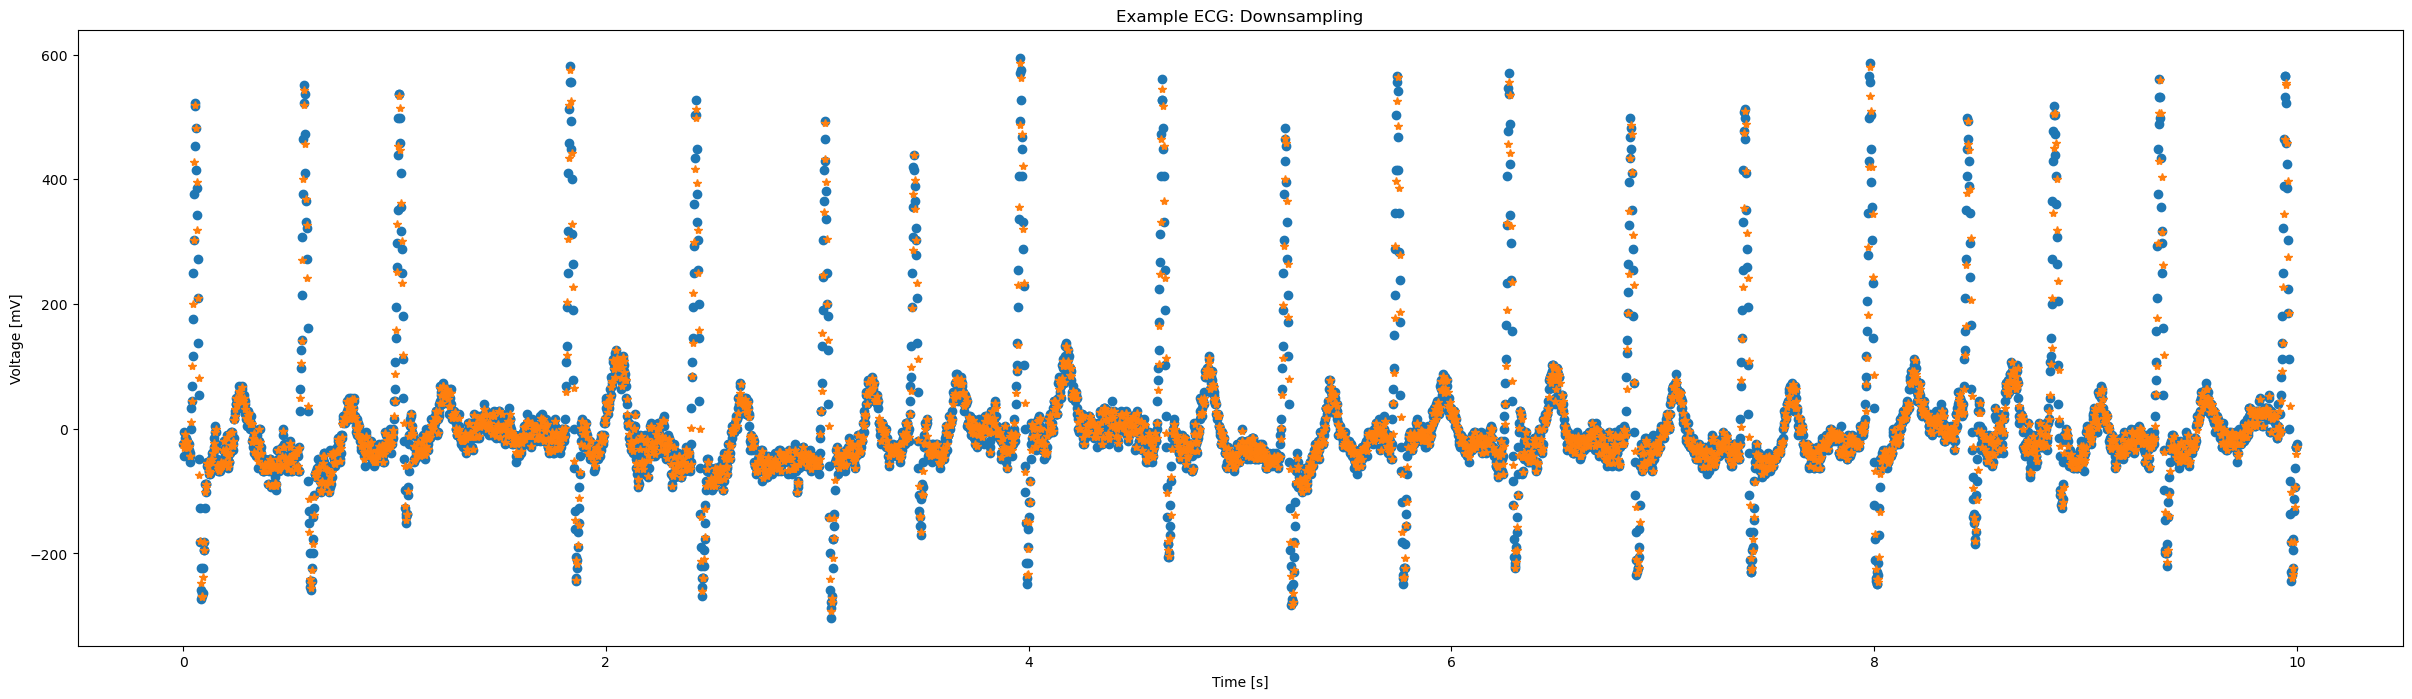

In [11]:
# get example data (evtl. TODO: nicer graphic)
ecg_fs_500 = sio.loadmat(PATH_CU_500+'MUSE_20180111_155154_74000.mat')['val'][0]
ecg_fs_300 = sio.loadmat(PATH_CU_300+'MUSE_20180111_155154_74000.mat')['val'][0]

# TEST
plt.figure(figsize=(30, 8))
plt.plot(np.linspace(0, len(ecg_fs_500)/500, len(ecg_fs_500)), ecg_fs_500, 'o', np.linspace(0, len(ecg_fs_300)/300, len(ecg_fs_300)), ecg_fs_300, '*')
plt.title('Example ECG: Downsampling')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [mV]')
plt.show()

### Category histogram

8528	 Dateien wurden geladen.
6877	 Dateien wurden geladen.
10646	 Dateien wurden geladen.


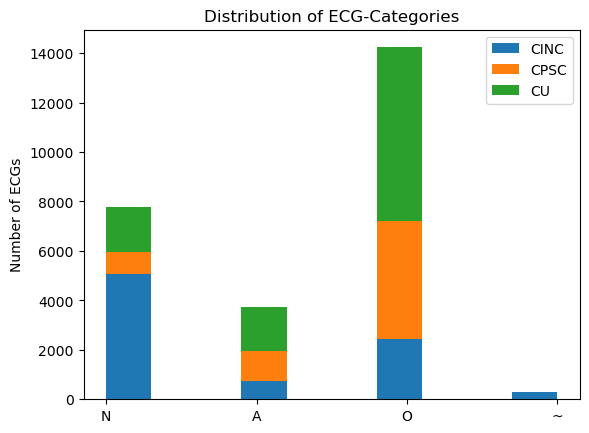

In [12]:
_, ecg_labels01, _, _ = load_references(folder=PATH_CINC)
_, ecg_labels02, _, _ = load_references(folder=PATH_CPSC_300)
_, ecg_labels03, _, _ = load_references(folder=PATH_CU_300)

plt.hist([ecg_labels01,ecg_labels02,ecg_labels03], histtype='barstacked', label=['CINC', 'CPSC', 'CU'])
plt.title('Distribution of ECG-Categories')
plt.ylabel('Number of ECGs')
plt.legend()
plt.show()

## Total data set

In [13]:
ecg_leads01, ecg_labels01, fs, ecg_names01 = load_references(folder=PATH_CINC)
ecg_leads02, ecg_labels02, fs, ecg_names02 = load_references(folder=PATH_CPSC_300)
ecg_leads03, ecg_labels03, fs, ecg_names03 = load_references(folder=PATH_CU_300)

8528	 Dateien wurden geladen.
6877	 Dateien wurden geladen.
10646	 Dateien wurden geladen.


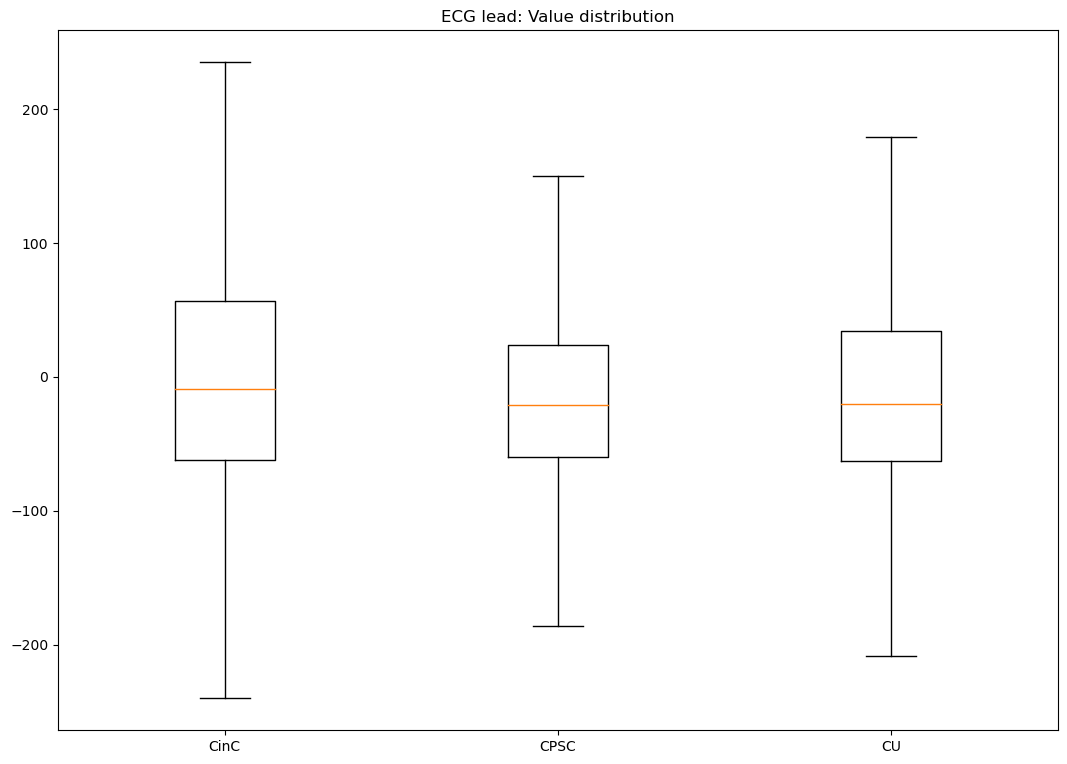

In [14]:
# plot the ecg_leads distribution

data = [np.concatenate(ecg_leads01), np.concatenate(ecg_leads02), np.concatenate(ecg_leads03)]

fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(data, showfliers=False)
ax.set_xticks([1, 2, 3], ['CinC', 'CPSC', 'CU'])
ax.set_title('ECG lead: Value distribution')
plt.show()

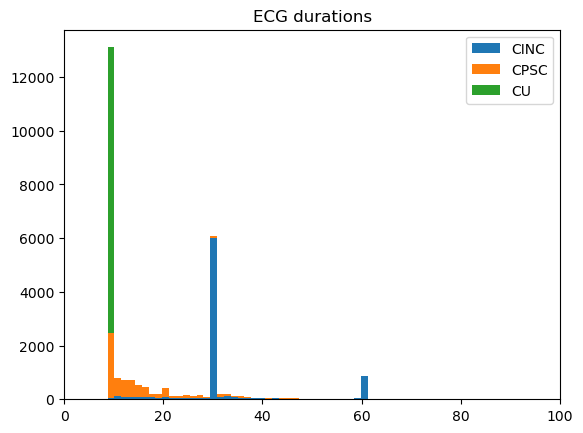

In [15]:
duration01 = [len(ecg)/300 for ecg in ecg_leads01]
duration02 = [len(ecg)/300 for ecg in ecg_leads02]
duration03 = [len(ecg)/300 for ecg in ecg_leads03]

plt.hist([duration01,duration02,duration03], histtype='barstacked', label=['CINC', 'CPSC', 'CU'], bins=100)
plt.title('ECG durations')
plt.xlim(0,100)
plt.legend()
plt.show()